In [1]:
import glob
import time
import pandas as pd
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

# Beware of the leading space!
angle_type_prefix = ' pose_R'
angle_type_prefix = ' p_r'

class Peak():
    def __init__(self, location, width, height):
        self.location = location
        self.width = width
        self.height = height

In [6]:
def get_peaks_params(head_class, angle_type, derivative=1):

    FRAME_RATE = 30
    all_widths = []
    all_heights = []

    for csv_file in glob.glob('./data/' + head_class + '/*.csv'):
        df = pd.read_csv(csv_file)

        # Resample to common frame rate
        csv_frame_rate = (df.shape[0] - 1) / np.sum(np.diff(df[' timestamp']))
        # print('csv frame rate: ', csv_frame_rate)
        n_resampled_points = int(1 + (len(df[angle_type]) - 1) * FRAME_RATE / csv_frame_rate)
        angles = scipy.signal.resample(df[angle_type], num=n_resampled_points)
        
        if derivative >= 1:
            angles = np.diff(angles)
            if derivative >= 2:
                angles = np.diff(angles)
        
        # Filter
        angles = scipy.signal.medfilt(angles, kernel_size=9)
#         fc = 5
#         b, a = scipy.signal.butter(N=2, Wn=2*fc/FRAME_RATE, btype='low', analog=False, output='ba')
#         angles = scipy.signal.filtfilt(b, a, angles)
        
        # Get peak locations, widths, and heights
        pos_peaks, _ = scipy.signal.find_peaks(angles)
        pos_heights, _, _ = scipy.signal.peak_prominences(angles, pos_peaks)
        
        neg_angles = np.abs(angles) - angles
        neg_peaks, _ = scipy.signal.find_peaks(neg_angles)
        neg_heights, _, _ = scipy.signal.peak_prominences(neg_angles, neg_peaks)
        
        # Detect neighboring +- and -+
        widths = []
        heights = []
        i, j = 0, 0
        while i < len(pos_peaks) and j < len(neg_peaks):
            widths.append(abs(pos_peaks[i] - neg_peaks[j]))
            heights.append(pos_heights[i] + neg_heights[j])
            # + -
            if pos_peaks[i] < neg_peaks[j]:
                i += 1
            # - +
            elif pos_peaks[i] > neg_peaks[j]:
                j += 1
            else:
                raise Exception('Postive and negative peaks coincide!')
                
        # If no peaks were found, skip
        if len(widths) == 0:
            continue
            
        # The highest peak is the representative of the series
        highest_peak_idx = np.argmax(heights)
#         print(widths[highest_peak_idx], heights[highest_peak_idx])
        
        all_widths.append(widths[highest_peak_idx])
        all_heights.append(heights[highest_peak_idx])

    return all_widths, all_heights


In [7]:
nod_x_widths,   nod_x_heights   = get_peaks_params(head_class='nod',   angle_type=angle_type_prefix+'x', derivative=1)
other_x_widths, other_x_heights = get_peaks_params(head_class='other', angle_type=angle_type_prefix+'x', derivative=1)


In [9]:
print(f'Mean width other: {np.mean(other_x_widths)}')
print(f'Mean height other: {np.mean(other_x_heights)}')

print(f'Mean width NOD: {np.mean(nod_x_widths)}')
print(f'Mean height NOD: {np.mean(nod_x_heights)}')

Mean width other: 10.76
Mean height other: 0.018108488345446185
Mean width NOD: 7.972222222222222
Mean height NOD: 0.04639938743348427


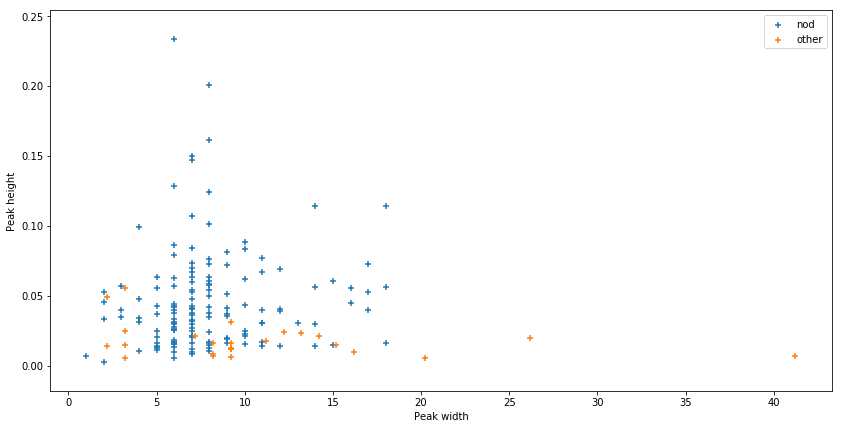

In [8]:
plt.figure(figsize=(14, 7))
plt.scatter(nod_x_widths, nod_x_heights, label='nod', marker='+')
plt.scatter(np.array(other_x_widths) + 0.2, other_x_heights, label='other', marker='+')
plt.xlabel('Peak width')
plt.ylabel('Peak height')
# plt.xlim(0.0, 50)
# plt.ylim(0.0, 0.005)
plt.legend()
plt.show()

In [17]:
plt.figure(figsize=(14, 7))
plt.bar(nod_x_widths, nod_x_heights, label='nod')
# plt.scatter(other_x_widths, other_x_heights, label='other', marker='+')
plt.xlabel('Peak width')
plt.ylabel('Peak height')
# plt.xlim(0.0, 50)
# plt.ylim(0.0, 0.005)
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
# plt.bar(nod_x_widths, nod_x_heights, label='nod')
plt.bar(other_x_widths, other_x_heights, label='other')
plt.xlabel('Peak width')
plt.ylabel('Peak height')
# plt.xlim(0.0, 50)
# plt.ylim(0.0, 0.005)
plt.legend()
plt.show()

KeyboardInterrupt: 